# 2D ERT modeling and inversion
## This one tries to copy the deposit shape and do a better image of the geothermal plume


I'll try to add the geothermal plume as a diffusing body, meanwhile I'll keep the plume the same as the simple model.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

print(pg.Report())


--------------------------------------------------------------------------------
  Date: Tue Aug 29 00:40:54 2023 -05

                OS : Linux
            CPU(s) : 8
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.6 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32)
  [GCC 12.3.0]

           pygimli : 1.4.3
            pgcore : 1.4.0
             numpy : 1.25.0
        matplotlib : 3.7.2
             scipy : 1.11.2
           IPython : 8.14.0
           pyvista : 0.41.1
--------------------------------------------------------------------------------


## Geometry definition

In [3]:
world = mt.createWorld(start=(-350, -250), end=(350, 0))

### Define geology below the deposit

Fault and inyection point definition

In [4]:
iPos = (-125, -200) #Inyection Point
fault = mt.createPolygon([iPos, (-150, -250)], isClosed= True)

Define Floresta and Cretacic

In [5]:
layer = mt.createPolygon([(-350, -150), iPos, (350, -150)], 
                         addNodes=100, interpolate='spline', isClosed=False)

Define Geometry

(<Axes: >, None)

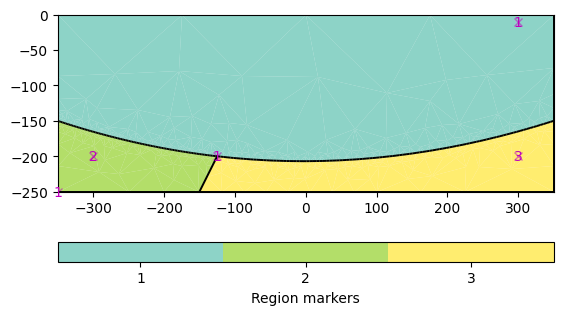

In [6]:
world += layer
world += fault

world.addRegionMarker((300, -10), marker=1)
world.addRegionMarker((-300, -200), marker=2)
world.addRegionMarker((300, -200), marker=3)

pg.show(world)

Create Mesh

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fb93e460280>)

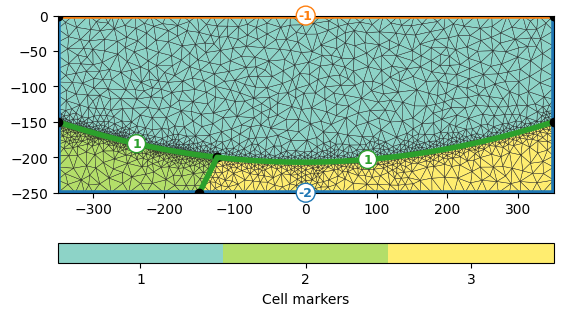

In [7]:
mesh = mt.createMesh(world, area = 200)
pg.show(mesh, markers=True, showMesh=True)

### Diffusion simulation for the geothermal plume

In [8]:
diff = pg.solver.cellValues(mesh, {2: pg.solver.createAnisotropyMatrix(0.1, 0.1, 0.0),
                                   3: pg.solver.createAnisotropyMatrix(0.1, 0.1, 0.0),
                                   1: pg.solver.createAnisotropyMatrix(1, 100, 20.0*np.pi/180)}
                                   )
iPosID = mesh.findNearestNode(iPos)


stationary solution concentration

Mesh:  Mesh: Nodes: 1860 Cells: 3604 Boundaries: 5463
Assembling time:  0.0761255
Solving time:  0.112009


/home/ubuntu_jc/anaconda3/envs/pg/lib/python3.10/site-packages/pygimli/viewer/mpl/meshview.py:1001: UserWarning: linewidths is ignored by contourf
  gci = ax.tricontourf(x, y, triangles, z,


1860 [100.0,...,77.10250951949274]


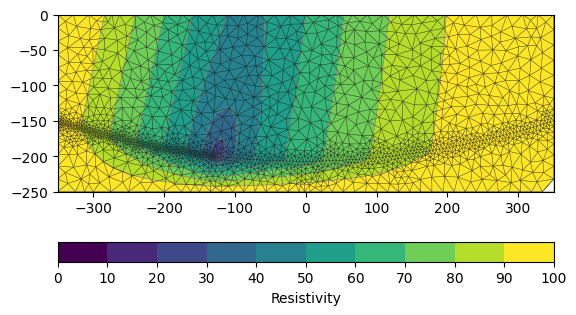

In [9]:
rho = pg.solver.solveFiniteElements(mesh, a=diff,
                    bc={'Dirichlet': {'-2': 100}, 'Neumann': {'-1': 1},
                        'Node':[iPosID, 1]}, verbose=True)


pg.show(mesh, rho, label='Resistivity', showMesh=True, 
        cMin=0, cMax=100,  nCols=10, nLevs=11, linewidths=0.5)

print(rho)

## Synthetic data generation
Create a Schlumberger ('slm') measuring scheme with 96 electrodes along a 700m line (-350 to 350)


In [10]:
scheme = ert.createData(elecs=np.linspace(start=-15, stop=15, num=21),
                           schemeName='dd')

for p in scheme.sensors():
    world.createNode(p)
    world.createNode(p - [0, 0.1])

rhomap = [[1, 100.],
          [2, 75.],
          [3, 50.]]

scheme = ert.createData(elecs=np.linspace(start=-350, stop=350, num=96),
                           schemeName='slm')

Perform the modeling with the mesh and the measuring scheme itself
and return a data container with apparent resistivity values,
geometric factors and estimated data errors specified by the noise setting.
The noise is also added to the data. Here 3% plus 1µV.
Note, we force a specific noise seed as we want reproducable results for
testing purposes.



In [12]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=3,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

ModellingBase::setMesh() copying new mesh ... Found datafile: 96 electrodes
Found: 96 free-electrodes
rMin = 3.68421, rMax = 1400
NGauLeg + NGauLag for inverse Fouriertransformation: 15 + 4
Found non-Neumann domain
0.0254313 s
FOP updating mesh dependencies ... 2e-06 s
Calculating response for model: min = relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.030000094328677677 : 0.03058907993149717
50 max = 100
Allocating memory for primary potential...... 0.0075249

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.473275s
Response: min = 15.393 max = 1683.5 mean = 119.132
Reciprocity rms(modelReciprocity) 1702.51%, max: 80007.3%


29/08/23 - 00:41:13 - pyGIMLi - INFO - 1.4145602616287072 6744.937043434872
29/08/23 - 00:41:13 - pyGIMLi - INFO - Simulated data Data: Sensors: 96 data: 2209, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
29/08/23 - 00:41:13 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
29/08/23 - 00:41:13 - pyGIMLi - INFO - Simulated rhoa (min/max) 13.103857079575654 1525.7278302633574
29/08/23 - 00:41:13 - pyGIMLi - INFO - Selected data noise %(min/max) 3.000009432867768 3.0589079931497167


Optional: you can filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



29/08/23 - 00:41:23 - pyGIMLi - INFO - Filtered rhoa (min/max) 13.103857079575654 1525.7278302633574


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fb93c287190>)

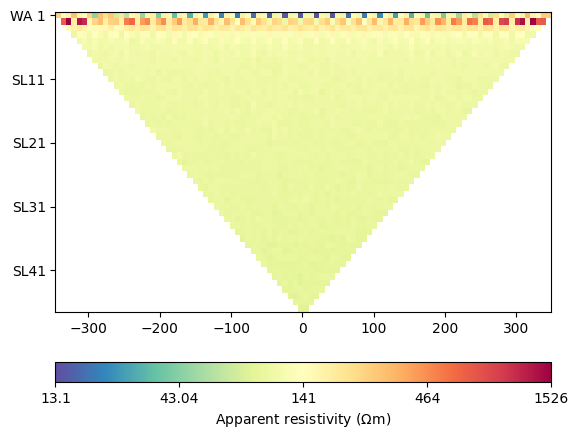

In [13]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('Forward_mod.dat')

# You can take a look at the data
ert.show(data)

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [14]:
mgr = ert.ERTManager('Forward_mod.dat')

Run the inversion with the preset data. 
Since I set noise level to 3%, chi^2 target should be close to 0.9 or sighly above, also the regularization parameter should be in the range of 10 to 50 (I chose 30).



In [ ]:
inv = mgr.invert(lam=30, verbose=True)
np.testing.assert_approx_equal(mgr.inv.chi2(), 0.9, significant=1)

Let the ERTManger show you the model of the last successful run and how it
fits the data. 
## Show data, model response, and model.



In [ ]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later